In [1]:
from utils import *

import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
import os
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, KFold, RandomizedSearchCV
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

import xgboost as xgb

sns.set_style('ticks')

## 0. Read and inspect data files

In [2]:
input_path = 'Data'

feature_file = 'deepnose_features.npy'
CID_file = 'molecules_train_cid.npy'

mixture_file = 'Mixure_Definitions_Training_set.csv'
training_task_file = 'TrainingData_mixturedist.csv'

# Deepnose features
features = np.load(os.path.join(input_path, feature_file))
# Training dataframe
training_set = pd.read_csv(os.path.join(input_path, training_task_file))

# Mapping helper files
mixtures_IDs = pd.read_csv(os.path.join(input_path, mixture_file))
features_CIDs = np.load(os.path.join(input_path, CID_file))
CID2features =  {CID: features[i] for i, CID in enumerate(features_CIDs)}

#### All features are positive!

In [3]:
features > 0

array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]])

#### Standard transform:

In [4]:
# Exponentiation
# features = np.exp(features)
# Standard transform features:
scaler = StandardScaler(with_mean=True, with_std=True)
features = scaler.fit_transform(features)

In [5]:
features > 0

array([[ True, False, False, ...,  True, False, False],
       [False, False,  True, ..., False, False, False],
       [ True, False,  True, ..., False, False, False],
       ...,
       [ True, False, False, ...,  True,  True, False],
       [ True, False, False, ...,  True,  True,  True],
       [False,  True, False, ..., False,  True, False]])

 <span style="color:orange;">NOTE: Sergey we need to discuss how to make use of `log(sum(exp(x)))` scheme: as standard normal makes some of the entries negative </span>

### 0.1 dataset sizes and prediction distribution 

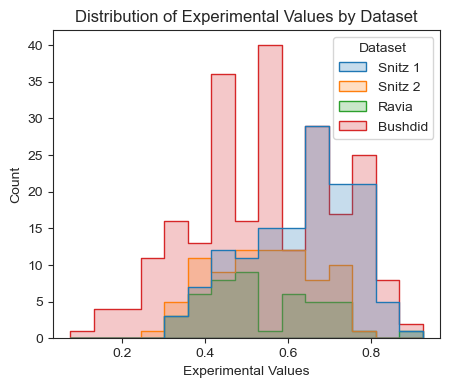

In [8]:
plt.figure(figsize = (5,4))
sns.histplot(data=training_set, x='Experimental Values', hue='Dataset', element="step")

plt.xlabel('Experimental Values')
plt.ylabel('Count')
plt.title('Distribution of Experimental Values by Dataset')

plt.show()

/Users/xinzheng/opt/anaconda3/envs/feedback/lib/python3.11/site-packages/seaborn/axisgrid.py:703: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_args = [v for k, v in plot_data.iteritems()]
/Users/xinzheng/opt/anaconda3/envs/feedback/lib/python3.11/site-packages/seaborn/axisgrid.py:703: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_args = [v for k, v in plot_data.iteritems()]
/Users/xinzheng/opt/anaconda3/envs/feedback/lib/python3.11/site-packages/seaborn/axisgrid.py:703: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_args = [v for k, v in plot_data.iteritems()]
/Users/xinzheng/opt/anaconda3/envs/feedback/lib/python3.11/site-packages/seaborn/axisgrid.py:703: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_args = [v for k, v in plot_data.iteritems()]


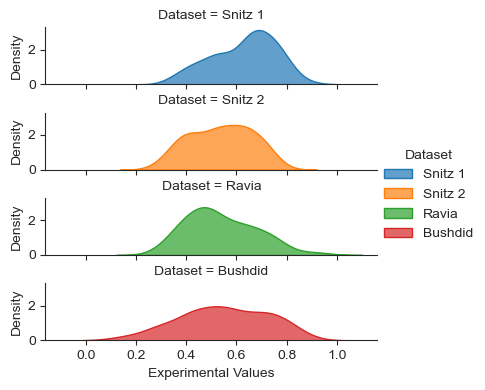

In [9]:
# Create a FacetGrid with dataset on each row:
g = sns.FacetGrid(training_set, row='Dataset', hue='Dataset', aspect=4, height=1)

# Map the KDE plot to the FacetGrid
g.map(sns.kdeplot, 'Experimental Values', fill=True, alpha=0.7)
g.add_legend()
g.fig.subplots_adjust(hspace=0.5)

plt.show()

### 0.2 Single molecule Deepnose feature dimension

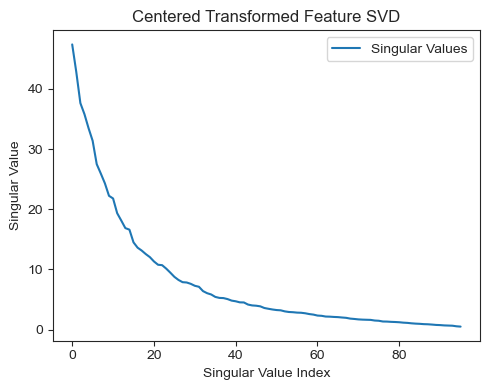

In [38]:
# Perform SVD on descriptors:
plt.figure(figsize=(5, 4))
U, s, Vh = np.linalg.svd(features, full_matrices=False)

# Plot singular values
plt.plot(s, label='Singular Values')

plt.xlabel('Singular Value Index')
plt.ylabel('Singular Value')
plt.title('Centered Transformed Feature SVD')

# Add legend
plt.legend()

plt.tight_layout()
plt.show()

#### Participation Ratio

- **Eval λ decay model** to interpret PR:

    - λ_i = λ exp(-i/k)
    - https://alexhwilliams.info/itsneuronalblog/2016/03/27/pca/

In [44]:
PR = np.sum(s)**2 / np.sum(s**2)
print(f'Participation ratio: {PR}')
print(f'Which implies that by a exponential decay model, k (dimensions that explains 86% variance) = {PR/2}')

Participation ratio: 36.83892091115316
Which implies that by a exponential decay model, k (dimensions that explains 86% variance) = 18.41946045557658


#### Effective Dimension

In [43]:
# Calculate the cumulative sum of squared singular values
cumulative_variance = np.cumsum(s**2) / np.sum(s**2)

# Choose a threshold for the desired amount of variance (e.g., 90%)
threshold = 0.90

# Find the smallest number of dimensions that exceed the threshold
effective_dimension = np.argmax(cumulative_variance >= threshold) + 1

print(f"Effective dimension for 90% variance: {effective_dimension}")

Effective dimension for 90% variance: 20


----

## 1. Organize mixture training dataset

In [40]:
# test molecule
test_mixture_unmixed_embeddings, test_CIDs = get_individual_embedding(1, "Snitz 1", mixtures_IDs, CID2features)
print('Number of molecules in this mixture:', test_mixture_unmixed_embeddings.shape[0])
print('Dimension of embedding:',  test_mixture_unmixed_embeddings.shape[1])

Number of molecules in this mixture: 10
Dimension of embedding: 96


- each `x` in `X` contains a two vector tuple `(mixture_1, mixture_2)`, index ordered same way as `training_set`
- `method` specifies the ways to create the mixture embeeding from 

In [41]:
X, y, num_mixtures, all_pairs_CIDs = format_Xy(training_set,  mixtures_IDs, CID2features, method = 'avg')

- `X_pairs`: concatinate the two molecule embeddings; so feature space is 96*2

- `X_features`:  add more engineered measures to `X_pairs`:

    - Eucledian distance;
    - Cosyne similarity (0, 1);
    - Angle (0, pi/2);
    - shared number of molecules between pair;
    - different number of molecules between pair;
    - one-hot of the dataset its from

<r/>

- `X_diff`: hasn't implemented, but the idea would be to get the difference for each embedding dimension

In [15]:
# Convert the input pairs to a suitable format for training
X_pairs = np.array([(np.concatenate((x1, x2))) for x1, x2 in X])
y_true = np.array(y)

In [16]:
X_pair1 = X_pairs[:, :96] 
X_pair2 = X_pairs[:, 96:] 

In [17]:
distances = [get_euclidean_distance(m[0], m[1]) for m in X]
similarities = [get_cosine_similarity(m[0], m[1]) for m in X]
angles = [get_cosine_angle(m[0], m[1]) for m in X]

In [18]:
shared_monos = [ len( set(pair[0]).intersection(set(pair[1]))) for pair in all_pairs_CIDs]
diff_monos = [ len( set(pair[0]).difference(set(pair[1]))) for pair in all_pairs_CIDs]

In [19]:
datasets = training_set['Dataset'].to_numpy()
encoder = OneHotEncoder()
data_arr = encoder.fit_transform(datasets.reshape(-1, 1))
data_arr = data_arr.toarray()

In [20]:
### add all information above
X_features = np.hstack((X_pairs, np.array(distances).reshape(500, 1), 
                        np.array(similarities).reshape(500, 1), 
                        np.array(angles).reshape(500, 1), 
                        np.array(shared_monos).reshape(500, 1), 
                        np.array(diff_monos).reshape(500, 1), 
                        np.array(num_mixtures), 
                        data_arr))

### Correlation between combined mixture embeddings and eperimetal values

In [45]:
dist_corr = np.corrcoef(distances, y_true)[0, 1]
print('R (Deepnose embedding Eucledian distance v.s Experimental Value): ', dist_corr)

R (Deepnose embedding Eucledian distance v.s Experimental Value):  0.27344674415525866


In [46]:
sim_corr = np.corrcoef(similarities, y_true)[0, 1]
print('R (Cosyne similarity v.s. Experimental Value): ', sim_corr)

R (Cosyne similarity v.s. Experimental Value):  -0.4916744250648624


In [47]:
sim_corr = np.corrcoef(angles, y_true)[0, 1]
print('R (Vector angle v.s. Experimental Value): ', sim_corr)

R (Vector angle v.s. Experimental Value):  0.502776273189954


In [48]:
training_set['Eucledian Dist'] = distances
training_set['Cosyne Sim'] = similarities
training_set['Angle'] = angles
training_set['Sum num monos'] = np.array(num_mixtures).sum(axis = 1)
training_set['Shared'] = shared_monos
training_set['Diff'] = diff_monos
training_set['Num mixture1'] = np.array(num_mixtures)[:, 0]
training_set['Num mixture2'] = np.array(num_mixtures)[:, 1]


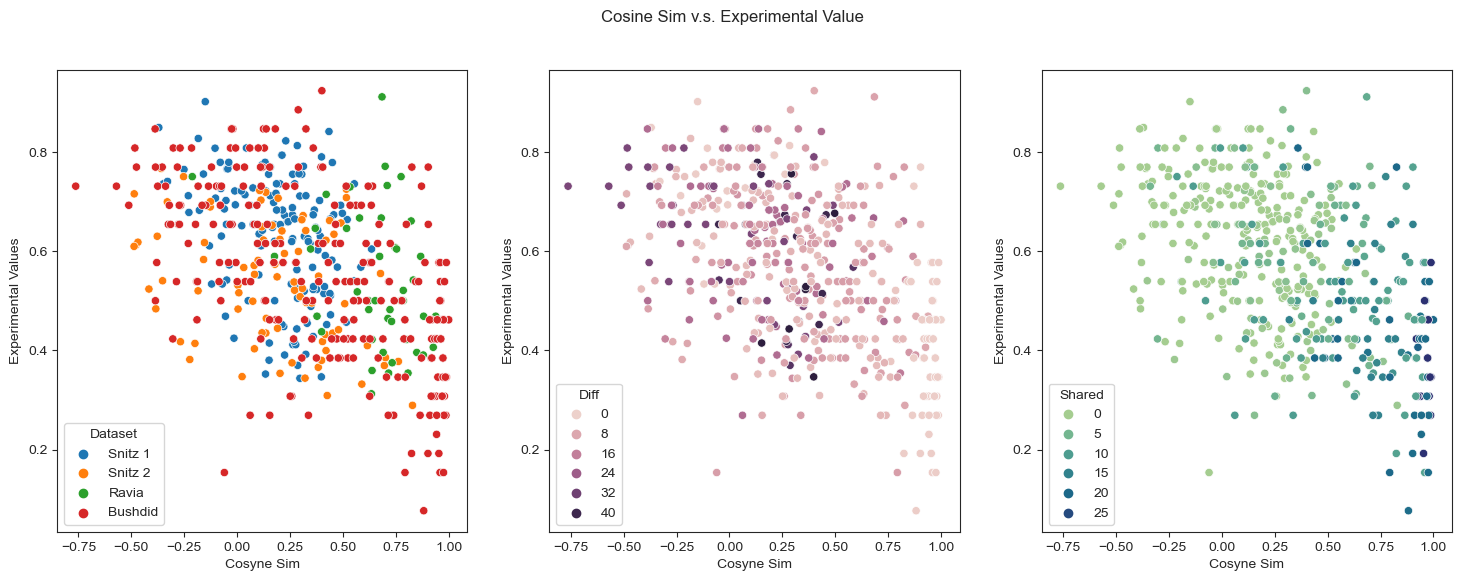

In [49]:
fig, ax = plt.subplots(ncols = 3, figsize = (18,6))
sns.scatterplot(data = training_set, x = 'Cosyne Sim', y = 'Experimental Values', hue = 'Dataset', ax = ax[0])
sns.scatterplot(data = training_set, x = 'Cosyne Sim', y = 'Experimental Values', hue = 'Diff', ax = ax[1])
sns.scatterplot(data = training_set, x = 'Cosyne Sim', y = 'Experimental Values', hue = 'Shared', ax = ax[2], palette= 'crest')

plt.suptitle('Cosine Sim v.s. Experimental Value')
plt.show()

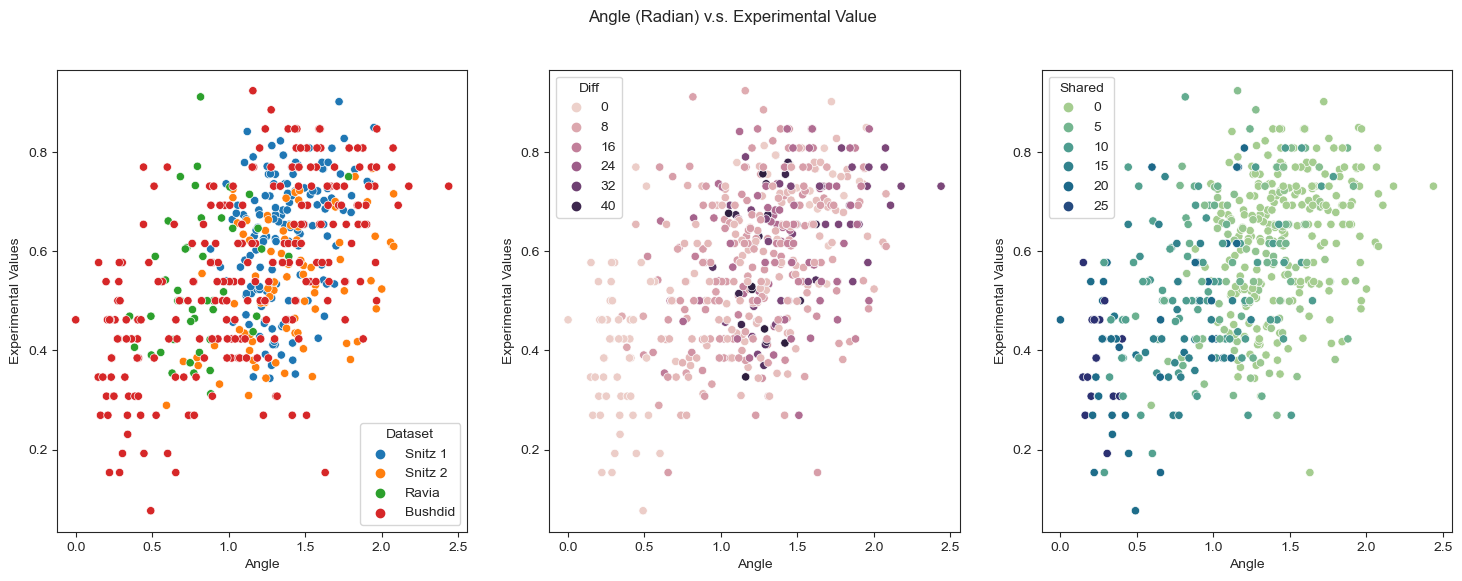

In [50]:
fig, ax = plt.subplots(ncols = 3, figsize = (18,6))
sns.scatterplot(data = training_set, x =  'Angle', y = 'Experimental Values', hue = 'Dataset', ax = ax[0])
sns.scatterplot(data = training_set, x = 'Angle', y = 'Experimental Values', hue = 'Diff', ax = ax[1])
sns.scatterplot(data = training_set, x = 'Angle', y = 'Experimental Values', hue = 'Shared', ax = ax[2], palette= 'crest')

plt.suptitle('Angle (Radian) v.s. Experimental Value')

plt.show()

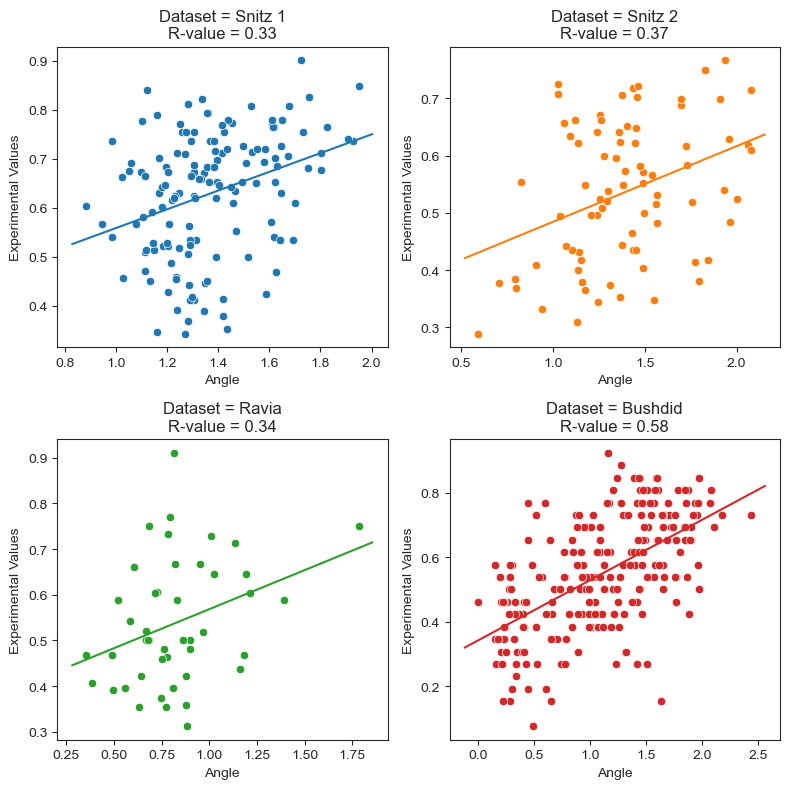

In [51]:

# Get the unique values in the 'Sum num mixture' column
unique_values = training_set['Dataset'].unique()

# Create a 2x2 grid of subplots
fig, axs = plt.subplots(2, 2, figsize=(8, 8))
axs = axs.flatten()

# Define the color palette
color_palette = ['C0', 'C1', 'C2', 'C3']

# Iterate over the unique values and create a scatter plot for each value
for i, value in enumerate(unique_values):
    # Filter the data based on the current value
    data_subset = training_set[training_set['Dataset'] == value]
    
    # Create a scatter plot for the current value
    sns.scatterplot(data=data_subset, x='Angle', y='Experimental Values', ax=axs[i], color=color_palette[i])
    
    # Calculate the regression line
    slope, intercept, r_value, _, _ = stats.linregress(data_subset['Angle'], data_subset['Experimental Values'])
    
    # Add the regression line to the subplot
    x_vals = np.array(axs[i].get_xlim())
    y_vals = intercept + slope * x_vals
    axs[i].plot(x_vals, y_vals, color=color_palette[i])
    
    # Set the title and add the R-value to the subplot
    axs[i].set_title(f"Dataset = {value}\nR-value = {r_value:.2f}")

# Adjust the spacing between subplots
plt.tight_layout()

# Display the plot
plt.show()

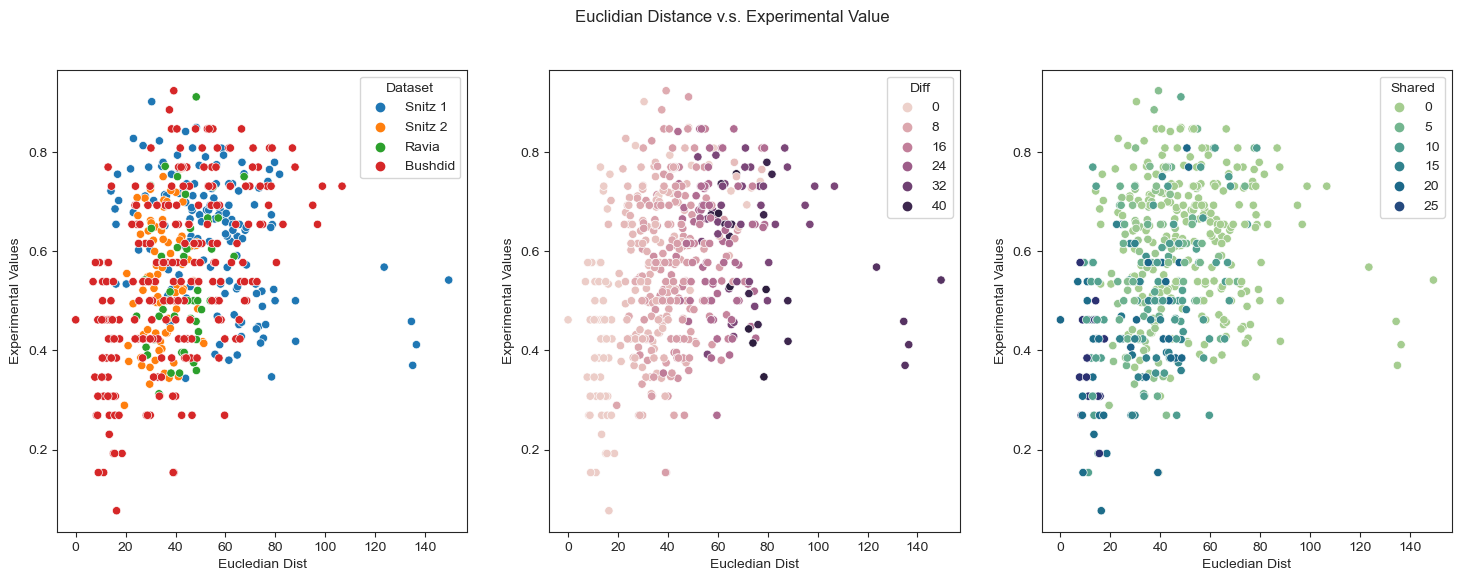

In [52]:
fig, ax = plt.subplots(ncols = 3, figsize = (18,6))
sns.scatterplot(data = training_set, x =  'Eucledian Dist', y = 'Experimental Values', hue = 'Dataset', ax = ax[0])
sns.scatterplot(data = training_set, x = 'Eucledian Dist', y = 'Experimental Values', hue = 'Diff', ax = ax[1])
sns.scatterplot(data = training_set, x = 'Eucledian Dist', y = 'Experimental Values', hue = 'Shared', ax = ax[2], palette= 'crest')

plt.suptitle('Euclidian Distance v.s. Experimental Value')

plt.show()

----
## 2. Training
### 2.1 Example attempt, standard intialized RF and XGBoost

In [53]:
n_folds = 10
seed = 314159

In [30]:
rf_pred_list = []
xgb_pred_list = []
y_true_list = []
test_indices_list = []  # Keep track of the test indices in each fold

# Perform k-fold cross-validation:
kf = KFold(n_splits=n_folds, shuffle=True, random_state=seed)
for train_index, test_index in kf.split(X_features):
    X_train, X_test = X_features[train_index], X_features[test_index]
    y_train, y_test = y_true[train_index], y_true[test_index]
    
    # Train the Random Forest regressor
    rf = RandomForestRegressor(n_estimators=100, random_state=seed)
    rf.fit(X_train, y_train)
    
    # Train the XGBoost regressor
    xgb_model = xgb.XGBRegressor(n_estimators=100, random_state=seed)
    xgb_model.fit(X_train, y_train)
    
    # Make predictions 
    rf_pred = rf.predict(X_test)
    xgb_pred = xgb_model.predict(X_test)
    
    rf_pred_list.extend(rf_pred)
    xgb_pred_list.extend(xgb_pred)
    y_true_list.extend(y_test)
    test_indices_list.extend(test_index)  # Store the test indices

# Store the predictions and actual values
results_df = pd.DataFrame({
    'test_index': test_indices_list,
    'rf_pred': rf_pred_list,
    'xgb_pred': xgb_pred_list,
    'y_true': y_true_list
})

# Merge the results with the training_set df
training_set = training_set.merge(results_df, left_index=True, right_on='test_index')
training_set.drop('test_index', axis=1, inplace=True)

In [31]:
training_set.head()

,Dataset,Mixture 1,Mixture 2,Experimental Values,Eucledian Dist,Cosyne Sim,Angle,Sum num monos,Shared,Diff,Num mixture1,Num mixture2,rf_pred,xgb_pred,y_true
150,Snitz 1,1,2,0.604167,29.781837,0.635303,0.882396,20,0,10,10,10,0.515971,0.518796,0.604167
300,Snitz 1,1,3,0.651042,35.711502,0.021838,1.548956,11,0,10,10,1,0.656069,0.651149,0.651042
0,Snitz 1,1,5,0.505208,44.335220,0.285229,1.281551,40,0,10,10,30,0.455150,0.439366,0.505208
1,Snitz 1,1,6,0.411458,57.686512,0.263618,1.304025,50,0,10,10,40,0.479809,0.478248,0.411458
50,Snitz 1,1,7,0.562500,37.102577,0.282499,1.284398,14,0,10,10,4,0.588975,0.573163,0.562500


In [32]:
# Calculate the correlation and R^2 for Random Forest
rf_corr = np.corrcoef(rf_pred_list, y_true_list)[0, 1]
rf_rmse = np.sqrt(mean_squared_error(np.array(y_true_list), np.array(rf_pred_list)))

print(f"Random Forest - R: {rf_corr:.3f}")
print(f"Random Forest - RMSE: {rf_rmse:.3f}")
print()
# Calculate the correlation and R^2 for XGBoost
xgb_corr = np.corrcoef(xgb_pred_list, y_true_list)[0, 1]
xgb_rmse = np.sqrt(mean_squared_error(np.array(y_true_list), np.array(xgb_pred_list)))

print(f"XGBoost - R: {xgb_corr:.3f}")
print(f"XGBoost - RMSE: {xgb_rmse:.3f}")


Random Forest - R: 0.576
Random Forest - RMSE: 0.128

XGBoost - R: 0.515
XGBoost - RMSE: 0.137


#### Observations:

1. RF although in this example has a better score, tends to predict a safe value

2. prediction are correlated for the two methods, off ones are predicted off in the same way..

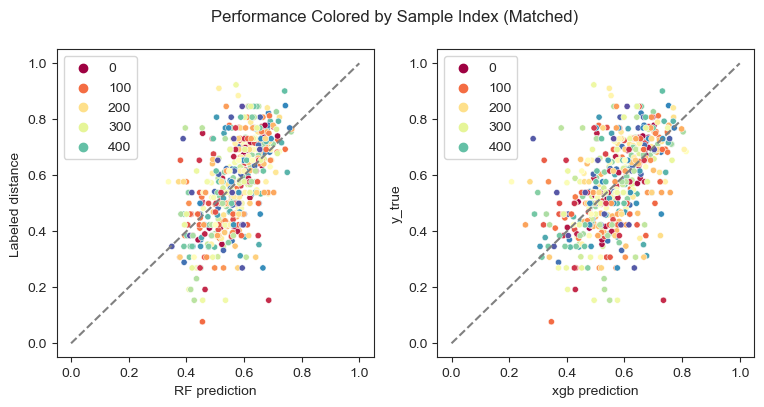

In [33]:
fig, ax = plt.subplots(ncols = 2, figsize = (9, 4))
sns.scatterplot(data = training_set, x = 'rf_pred', y = 'y_true', hue = training_set.index, ax = ax[0], s = 20, palette= 'Spectral')
ax[0].set_xlabel("RF prediction")
ax[0].set_ylabel("Labeled distance")
ax[0].plot([0, 1],[0, 1], c = 'gray', ls = '--')

sns.scatterplot(data = training_set, x = 'xgb_pred', y = 'y_true', hue = training_set.index, ax = ax[1], s = 20, palette= 'Spectral')
ax[1].set_xlabel("xgb prediction")
ax[1].plot([0, 1],[0, 1], c = 'gray', ls = '--')
fig.suptitle('Performance Colored by Sample Index (Matched)')

plt.show()

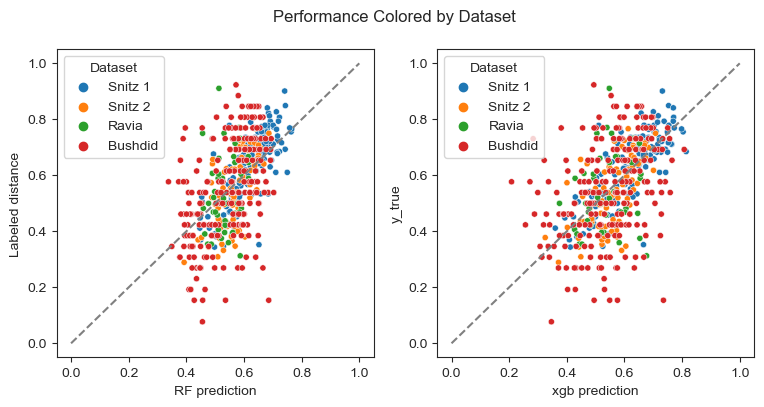

In [34]:
fig, ax = plt.subplots(ncols = 2, figsize = (9, 4))
sns.scatterplot(data = training_set, x = 'rf_pred', y = 'y_true', hue = 'Dataset', ax = ax[0], s = 20)
ax[0].set_xlabel("RF prediction")
ax[0].set_ylabel("Labeled distance")
ax[0].plot([0, 1],[0, 1], c = 'gray', ls = '--')

sns.scatterplot(data = training_set, x = 'xgb_pred', y = 'y_true', hue = 'Dataset', ax = ax[1], s = 20)
ax[1].set_xlabel("xgb prediction")
ax[1].plot([0, 1],[0, 1], c = 'gray', ls = '--')

fig.suptitle('Performance Colored by Dataset')
plt.show()

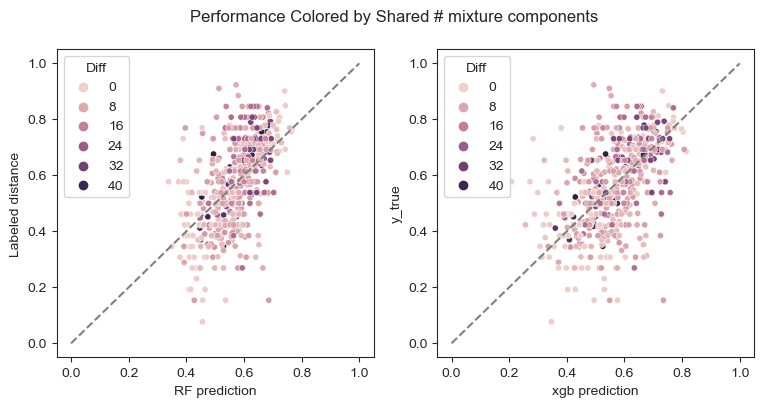

In [35]:
fig, ax = plt.subplots(ncols = 2, figsize = (9, 4))
sns.scatterplot(data = training_set, x = 'rf_pred', y = 'y_true', hue = 'Diff', ax = ax[0], s = 20)
ax[0].set_xlabel("RF prediction")
ax[0].set_ylabel("Labeled distance")
ax[0].plot([0, 1],[0, 1], c = 'gray', ls = '--')

sns.scatterplot(data = training_set, x = 'xgb_pred', y = 'y_true', hue = 'Diff', ax = ax[1], s = 20)
ax[1].set_xlabel("xgb prediction")
ax[1].plot([0, 1],[0, 1], c = 'gray', ls = '--')

fig.suptitle('Performance Colored by Shared # mixture components')

plt.show()

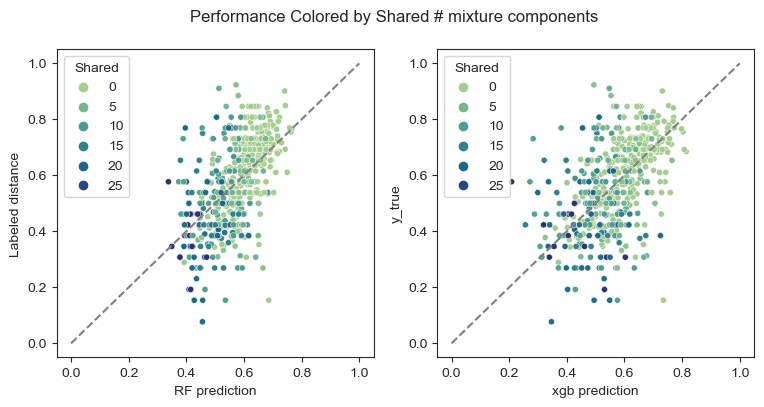

In [36]:
fig, ax = plt.subplots(ncols = 2, figsize = (9, 4))
sns.scatterplot(data = training_set, x = 'rf_pred', y = 'y_true', hue = 'Shared', ax = ax[0], s = 20, palette= 'crest')
ax[0].set_xlabel("RF prediction")
ax[0].set_ylabel("Labeled distance")
ax[0].plot([0, 1],[0, 1], c = 'gray', ls = '--')

sns.scatterplot(data = training_set, x = 'xgb_pred', y = 'y_true', hue = 'Shared', ax = ax[1], s = 20, palette= 'crest')
ax[1].set_xlabel("xgb prediction")
ax[1].plot([0, 1],[0, 1], c = 'gray', ls = '--')
fig.suptitle('Performance Colored by Shared # mixture components')

plt.show()